In [1]:
import sys
import matplotlib.pyplot as plt
import json
import os
import numpy as np
import pandas as pd
import itertools
import cmdstanpy
import jax
from jax.experimental import optimizers
import jax.scipy as jsc
import jax.numpy as jnp
import urllib
import shutil
from scipy.stats import norm
from sklearn.model_selection import train_test_split
# required install (the rest is preinstalled)
#fast cmdstanpy install
# #(faster than compiling from source via install_cmdstan() function)
# tgz_file = 'colab-cmdstan-2.23.0.tar.gz'
# tgz_url = 'https://github.com/stan-dev/cmdstan/releases/download/v2.23.0/colab-cmdstan-2.23.0.tar.gz'
# if not os.path.exists(tgz_file):
#     urllib.request.urlretrieve(tgz_url, tgz_file)
#     shutil.unpack_archive(tgz_file)
#import pybrms
from matplotlib import pyplot as plt
#######
import contextPolicy #robust_optimization/src/contextPolicy.py
from generator import sim_y_barThetax, sim_ThetaXy
from contextPolicy import argmin_lpred, argmin_lopt_bar_argmin_lpred, argmin_lopt_emp, train_test_w
from loss import lopt_NV
from sklearn.model_selection import train_test_split

## Specified

Assuming a normal for conditional distribution, a closed form equation exist that returns expected loss given the true parameter, predictor, and preparation amount. Two performance measures will be used $E_{Y|X}[Cost(W_{\theta}(x), y)|X]$ and $E_X[E_{Y|X}[Cost(W_{\theta}(x), y)|X]]$.
E[profit]
$P_{Y|X}^* = P_{Y|X}^{\theta^*}$ 
=E_{Y|X}[profit|q<D]P(q<D)+E[profit|q>=D]P(q>=D)$

= $(pq-cq) * F(q) + \int_{-\infty}^q (px-cq)f(x)dx * (1-F(q))$
= Expe

$q = \theta' x + \Phi^{-1}(.8)$
what1 
q of N(\theta'x, 1) distribution

Given the demand has $N(\theta'x, 1)$ distribution, 
4 * q * norm.ppf(q) + 



In [2]:
test_size = 100000
train_size  = 1024
# 1. plot for train, test loss for increasing trainset
train_err = pd.DataFrame()
test_err = pd.DataFrame()
train_err_m = pd.DataFrame()
test_err_m = pd.DataFrame()
X, ys, Thetastar = sim_ThetaXy(n_gen= train_size + test_size)
X_train_ori, X_test, y_w_train_ori, y_w_test = train_test_split(X, ys[0], train_size = 1024)
_, _, y_m_train_ori, y_m_test = train_test_split(X, ys[1], train_size = 1024)
for train_size in np.power(2, [i for i in range(1,11)]):
    # well-specified has closed form but using simulated
    X_train = X_train_ori[:train_size]
    y_w_train = y_w_train_ori[:train_size]
    y_m_train = y_m_train_ori[:train_size]
    # get_w
    train_df, test_df = train_test_w(X_train, X_test, y_w_train, y_w_test, Thetastar)
    
    # compute train loss with w, theta
    err_w1_train_anal = lopt_NV(train_df.w1, input_type = "Theta", X = X_train, Thetastar = Thetastar)
    err_w2_train_anal = lopt_NV(train_df.w2, input_type = "Theta", X = X_train, Thetastar = Thetastar)
    train_err = train_err.append({'w1_anal':err_w1_train_anal, 'w2_anal': err_w2_train_anal} , ignore_index=True)
#     err_w1_train_sim = lopt_NV(train_df.w1, Y = y_w_train) 
#     err_w2_train_sim = lopt_NV(train_df.w2, Y = y_w_train)
#    train_err = train_err.append({'w1_anal':err_w1_train_anal, 'w2_anal': err_w2_train_anal, 'w1_sim':err_w1_train_sim, 'w2_sim': err_w2_train_sim} , ignore_index=True)
    
    # compute train loss with w, theta
    err_w1_test_anal = lopt_NV(test_df.w1, input_type = "Theta", X = X_test, Thetastar = Thetastar) 
    err_w2_test_anal = lopt_NV(test_df.w2, input_type = "Theta",  X = X_test, Thetastar = Thetastar)
    test_err = test_err.append({'w1':err_w1_test_anal, 'w2': err_w2_test_anal} , ignore_index=True)
#     err_w1_test_sim = lopt_NV(train_df.w1, Y = y_w_test)
#     err_w2_test_sim = lopt_NV(train_df.w2, Y = y_w_test)
#    test_err = test_err.append({'w1_anal':err_w1_test_anal, 'w2_anal': err_w2_test_anal, 'w1_sim':err_w1_test_sim, 'w2_sim': err_w2_test_sim}, ignore_index=True)
    
#     # misspecified: # no closed form
#     #get_w    
#     train_df_m, test_df_m = train_test_w(X_train, X_test, y_m_train, y_m_test, Thetastar)
    
#     # compute train loss with w, theta
#     err_w1m_train = lopt_NV(train_df_m.w1, Y = y_m_train)
#     err_w2m_train = lopt_NV(train_df_m.w2, Y = y_m_train)
#     train_err_m = train_err_m.append({'w1':err_w1m_train, 'w2': err_w2m_train} , ignore_index=True)
    
# #     # compute test loss with w, theta    
#     err_w1m_test = lopt_NV(train_df_m.w1, Y = y_m_test)
#     err_w2m_test = lopt_NV(train_df_m.w2, Y = y_m_test)
#     test_err_m = test_err_m.append({'w1':err_w1m_test, 'w2': err_w2m_test} , ignore_index=True)

err= train_err.copy()
err["w1_test_anal"] = test_err.w1_anal
err["w2_test_anal"] = test_err.w2_anal
err["w1_test_sim"] = test_err.w1_sim
err["w2_test_sim"] = test_err.w2_sim
err.plot(xlim = [1, 10], figsize = (15, 9), xlabel = "log2(trainsize)", ylabel = "loss")
# err_m = train_err_m.copy()
# err_m["w1m_test"] = test_err_m.w1
# err_m["w2m_test"] = test_err_m.w2
# err_m.plot(xlim = [1, 10], figsize = (15, 9), xlabel = "log2(trainsize)", ylabel = "loss")

# train_df.to_pickle("train_df.pkl")
# test_df.to_pickle("test_df.pkl")
# train_df = pd.read_pickle("train_df.pkl")
# test_df = pd.read_pickle("test_df.pkl")


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /Users/hyunjimoon/GoogleDrive/Colab Notebooks/robust_optimization/src/stan/optTheta_lpred
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4


loss -762.927909779324 Thetastar [5. 6.] theta (4.25, 5.1)
loss -765.3963079470423 Thetastar [5. 6.] theta (4.280612244897959, 5.1)
loss -767.8647061147606 Thetastar [5. 6.] theta (4.311224489795919, 5.1)
loss -770.3331042824789 Thetastar [5. 6.] theta (4.341836734693878, 5.1)
loss -772.8015024501972 Thetastar [5. 6.] theta (4.372448979591836, 5.1)
loss -775.2699006179153 Thetastar [5. 6.] theta (4.403061224489796, 5.1)
loss -777.7382987856337 Thetastar [5. 6.] theta (4.433673469387755, 5.1)
loss -780.2066969533519 Thetastar [5. 6.] theta (4.464285714285714, 5.1)
loss -782.6750951210702 Thetastar [5. 6.] theta (4.494897959183674, 5.1)
loss -785.1434932887885 Thetastar [5. 6.] theta (4.525510204081632, 5.1)
loss -787.6118914565068 Thetastar [5. 6.] theta (4.5561224489795915, 5.1)
loss -790.0802896242251 Thetastar [5. 6.] theta (4.586734693877551, 5.1)
loss -792.5486877919433 Thetastar [5. 6.] theta (4.61734693877551, 5.1)
loss -795.0170859596617 Thetastar [5. 6.] theta (4.64795918367346

KeyboardInterrupt: 

In [7]:
err_m

,w1,w2,w1m_test,w2m_test
0,-1.480650e+49,-494.886540,1.074915e+49,-494.886540
1,-1.766124e+52,-507.054737,4.034866e+52,-507.054737
2,9.037932e+50,-508.238424,2.248879e+52,-508.238424
3,1.316144e+55,-507.580418,2.384838e+55,-507.580418
4,1.168150e+55,-516.935622,1.516049e+55,-516.935622
5,6.762846e+54,-512.108004,6.948261e+54,-512.108004
6,3.606561e+54,-506.602455,4.245024e+54,-506.602455
7,3.268797e+54,-508.918150,3.706612e+54,-508.918150
8,3.943857e+57,-510.418058,3.975220e+57,-510.418058
9,1.978939e+57,-510.065389,1.987885e+57,-510.065389


,w1,w2,w1m_test,w2m_test
0,-1.480650e+49,-494.886540,1.074915e+49,-494.886540
1,-1.766124e+52,-507.054737,4.034866e+52,-507.054737
2,9.037932e+50,-508.238424,2.248879e+52,-508.238424
3,1.316144e+55,-507.580418,2.384838e+55,-507.580418
4,1.168150e+55,-516.935622,1.516049e+55,-516.935622
5,6.762846e+54,-512.108004,6.948261e+54,-512.108004
6,3.606561e+54,-506.602455,4.245024e+54,-506.602455
7,3.268797e+54,-508.918150,3.706612e+54,-508.918150
8,3.943857e+57,-510.418058,3.975220e+57,-510.418058
9,1.978939e+57,-510.065389,1.987885e+57,-510.065389


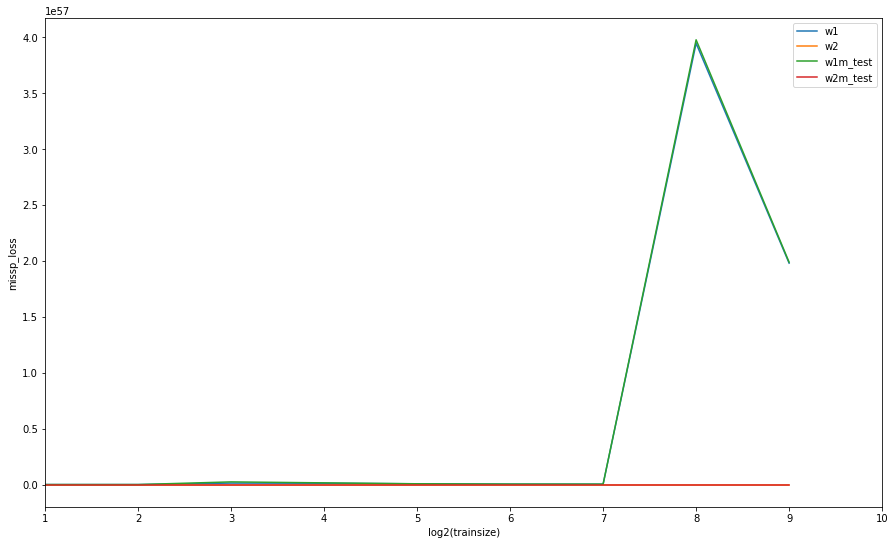

In [4]:
err_m.plot(xlim = [1, 10], figsize = (15, 9), xlabel = "log2(trainsize)", ylabel = "missp_loss")
err_m

In [ ]:
pd.concat([err, err_m], join= "outer")

,w1,w2,w1_test,w2_test,w1m_test,w2m_test
0,-4.265650e+02,-427.356812,-430.783797,-427.606628,NaN,NaN
1,-4.371561e+02,-437.883612,-432.820404,-430.789070,NaN,NaN
2,-4.381739e+02,-438.930422,-432.512329,-431.633978,NaN,NaN
3,-4.375945e+02,-438.340129,-430.464000,-429.295720,NaN,NaN
4,-4.457391e+02,-446.474849,-423.813166,-423.152142,NaN,NaN
5,-4.415400e+02,-442.265062,-427.133150,-426.040459,NaN,NaN
6,-4.367564e+02,-437.467492,-423.832067,-422.678782,NaN,NaN
7,-4.387684e+02,-439.483633,-422.064505,-420.980231,NaN,NaN
8,-4.400728e+02,-440.782618,-419.914266,-418.918477,NaN,NaN
9,-4.397666e+02,-440.477941,-419.601327,-418.568802,NaN,NaN


## misspecified

Approach1 is better when well-specified.

## Misspecification type 1: degree

In [ ]:
ym1 = np.array(df.ym1)
df['what1_m']= argmin_lopt_bar_argmin_lpred(MClass, P_ybarx, yw, X) #MClass = "lin"
df['what2_m']= argmin_lopt_emp(P_ybarx, ym1, X)
print(np.mean([-(profit * min(w, y) - cost * w) for w, y in zip(df.ym1, df.what1_m)]))
print(np.mean([-(profit * min(w, y) - cost * w) for w, y in zip(df.ym1, df.what2_m)]))
#3.23, 3.57
#2.95, 3.08

NameError: name 'df' is not defined

## Misspecification type 2: distribution

In [ ]:
ym2 = np.array(df.ym2)
df['what1_m2']= argmin_lopt_bar_argmin_lpred(MClass, P_ybarx, ym2, X) #MClass = "lin"
df['what2_m2']= argmin_lopt_emp(P_ybarx, ym2, X)
print(np.mean([-(profit * min(w, y) - cost * w) for w, y in zip(df.ym2, df.what1)]))
print(np.mean([-(profit * min(w, y) - cost * w) for w, y in zip(df.ym2, df.what2)]))
# -1.7073
# -1.5114
# approach 1 better so far.

In [ ]:

def check_random_state(seed):
    """Turn seed into a np.random.RandomState instance
    Parameters
    ----------
    seed : None, int or instance of RandomState
        If seed is None, return the RandomState singleton used by np.random.
        If seed is an int, return a new RandomState instance seeded with seed.
        If seed is already a RandomState instance, return it.
        Otherwise raise ValueError.
    """
    if seed is None or seed is np.random:
        return np.random.mtrand._rand
    if isinstance(seed, numbers.Integral):
        return np.random.RandomState(seed)
    if isinstance(seed, np.random.RandomState):
        return seed
    raise ValueError('%r cannot be used to seed a numpy.random.RandomState'
                     ' instance' % seed)
generator = check_random_state(None)
abs(generator.rand(2, 1))#100 *


# questions
#### Implementation
## policy.py 
`argmin_l_pred's MClass`
1. Can you give me some example of model class other than linear? 
2. Unlike Adam's previous comment on $y \sim N(\theta' X'X, 1)$ `quad` could be elementwise power $X^2 (n*p)$? (vs $X'X (p*p)$)
3. How to improve grid search of theta in approach2?

#### Experiment design
1.  What setting could make approach 2 outperform for distribution misspecification like it does in degree of predictor misspecification? Is this misspecification type needed?

#### Theory
1. Could approach1 also be thought as empirical risk minization? As the solution depends on the dataset (x_i, y_i) at $\theta_1$ estimation level, I think it could be. Is this is why you used $\hat{w}$, not $w*$, Henry?
2. Is it awkward to express the cost funciton as $l_{opt}$? Thought the input is w, y underneath, it could be implicitly rearranged as function of $\hat{\theta}, \theta$.
3. Does having a feature related to parameteric optimization?
4. $H_\theta := P_\theta()$ is this notation correct?
5. Is Remark2 (P(.) combinatorial/MIP) from SPO paper applicable for approach2? 
$w^{∗}(c) \in \underset{w \in \tilde{S}}{argmin} l_{opt}(w, y)⊆ \underset{w \in S}{argmin} l_{opt}(w, y)$ where S, $\tilde{S}$ are feasible set and its closed convex hull.